In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def radial_frequency_filter(image, filter_type='bandreject', radius=50, bandwidth=10):
    """
    Apply a radial frequency filter (bandreject or bandpass) to an image.

    Parameters:
        image (ndarray): Input 2D grayscale image
        filter_type (str): 'bandreject' or 'bandpass'
        radius (float): Center frequency of the radial filter
        bandwidth (float): Width of the band

    Returns:
        filtered_image (ndarray): Image filtered in frequency domain
    """
    # 1. FFT and shift
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # 2. Construct radial mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    Y, X = np.ogrid[:rows, :cols]
    D = np.sqrt((X - ccol)**2 + (Y - crow)**2)

    if filter_type == 'bandreject':
        mask = np.logical_or(D < (radius - bandwidth/2), D > (radius + bandwidth/2)).astype(np.float32)
    elif filter_type == 'bandpass':
        mask = np.logical_and(D >= (radius - bandwidth/2), D <= (radius + bandwidth/2)).astype(np.float32)
    else:
        raise ValueError("filter_type must be 'bandreject' or 'bandpass'")

    # 3. Apply filter in frequency domain
    f_filtered = fshift * mask

    # 4. Inverse FFT
    f_ishift = np.fft.ifftshift(f_filtered)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)

    return f, fshift, D, f_filtered, img_filtered, mask

# Load grayscale image
image = np.genfromtxt('thinfilm-on-substrate.csv', delimiter=',')




In [72]:
# Apply radial bandreject filter
f, fshift, D, f_filtered, filtered_image, mask = radial_frequency_filter(image, filter_type='bandpass', radius=5, bandwidth=10)
f, fshift, D, f_filtered, filtered_image, mask = radial_frequency_filter(image, filter_type='bandreject', radius=10, bandwidth=20)


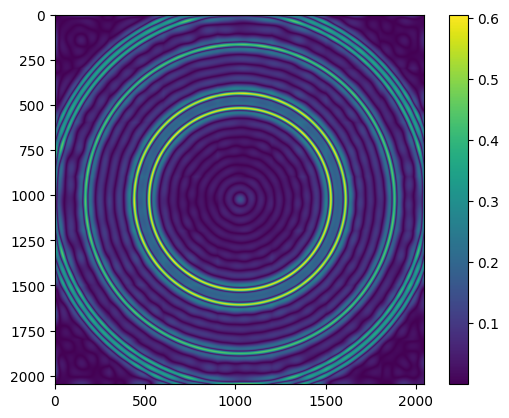

In [73]:
plt.imshow(filtered_image, cmap='viridis')
plt.colorbar()

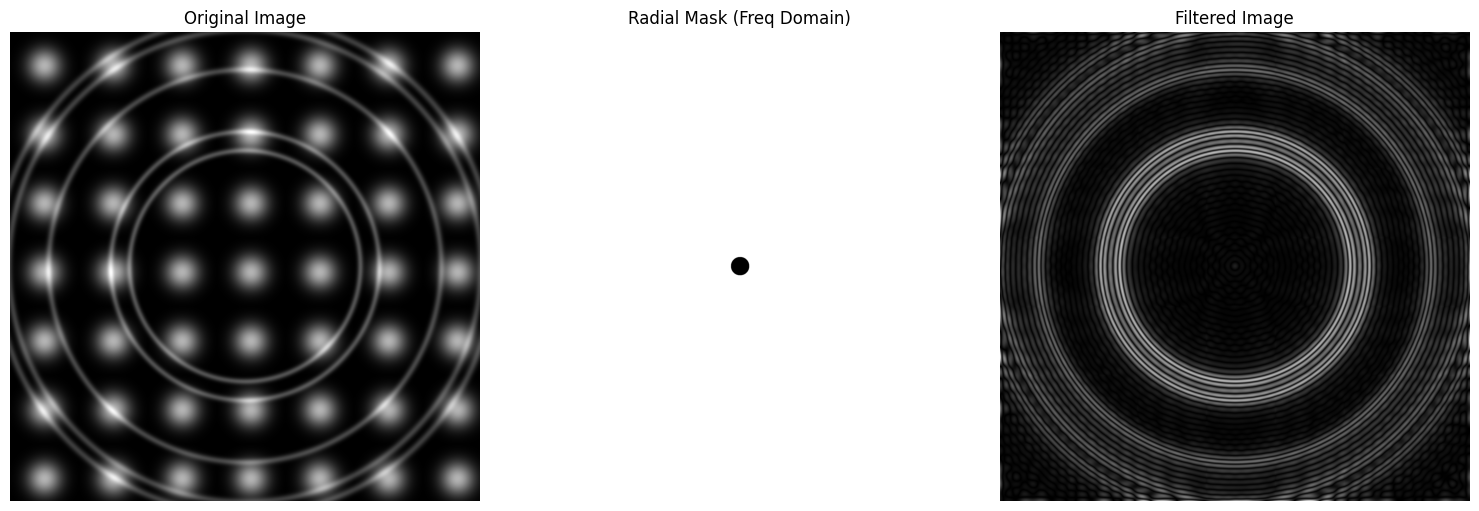

In [64]:

# Display
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Radial Mask (Freq Domain)")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

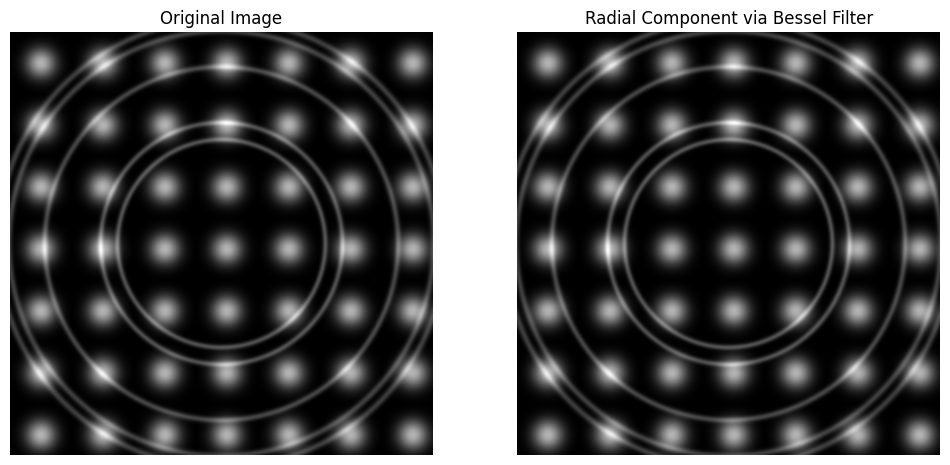

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.special import jv  # Bessel function of the first kind
from skimage import io, color

def bessel_lowpass_filter(shape, cutoff, order=0):
    """
    Create a radial Bessel lowpass filter in frequency domain.

    Parameters:
        shape (tuple): shape of the filter (height, width)
        cutoff (float): normalized cutoff frequency (0 to 0.5)
        order (int): order of the Bessel function (typically 0 for isotropic radial)

    Returns:
        2D numpy array with the filter in Fourier domain
    """
    rows, cols = shape
    u = np.fft.fftfreq(rows).reshape(-1, 1)
    v = np.fft.fftfreq(cols).reshape(1, -1)
    r = np.sqrt(u**2 + v**2)
    bessel_response = jv(order, 2 * np.pi * cutoff * r)
    bessel_response /= np.max(np.abs(bessel_response))  # normalize
    return np.abs(bessel_response)  # ensure magnitude only


def apply_bessel_filter(image, cutoff=0.1, order=0):
    if image.ndim == 3:
        image = color.rgb2gray(image)

    F = fftpack.fftshift(fftpack.fft2(image))
    H = bessel_lowpass_filter(image.shape, cutoff, order)
    F_filtered = F * H
    image_filtered = np.real(fftpack.ifft2(fftpack.ifftshift(F_filtered)))
    return image_filtered

# Example usage
filtered_image = apply_bessel_filter(image, cutoff=0.01, order=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Radial Component via Bessel Filter")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')
plt.show()

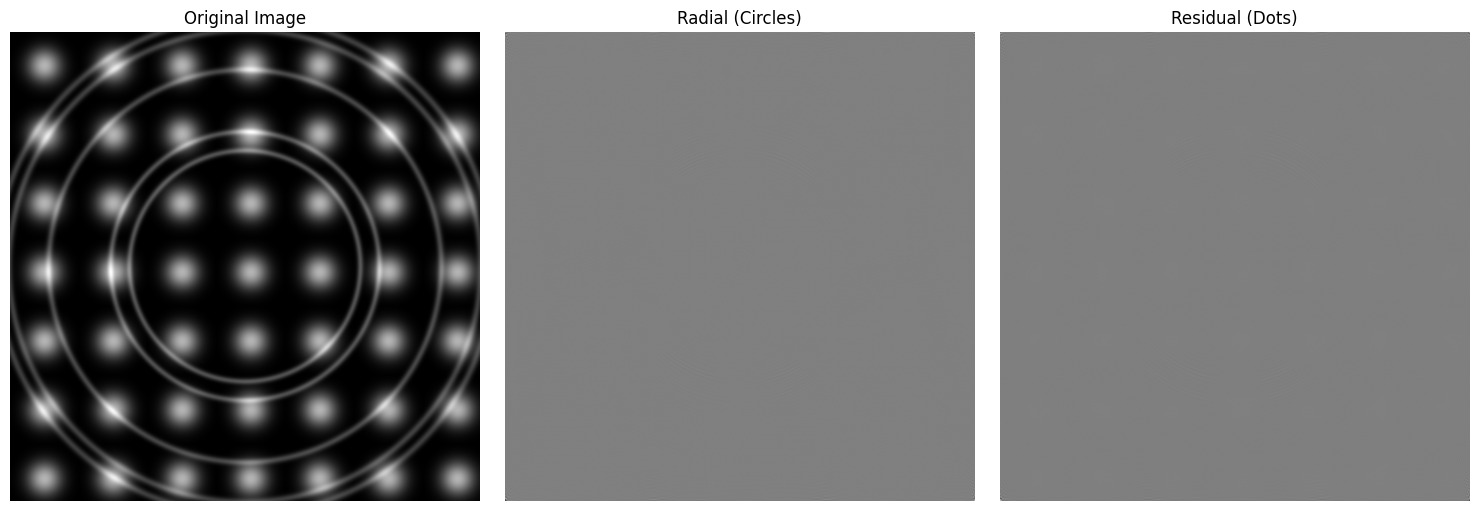

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp_polar, warp
from skimage.color import rgb2gray
from skimage.util import img_as_float
from skimage import data

def extract_radial_and_residual(image, scaling='log'):
    image = img_as_float(image)
    shape = image.shape
    center = (shape[0] // 2, shape[1] // 2)

    # 1. FFT
    F = np.fft.fftshift(np.fft.fft2(image))
    mag = np.abs(F)
    phase = np.angle(F)

    # 2. Warp to polar coordinates
    polar_mag = warp_polar(mag, center=center, scaling=scaling)

    # 3. Angular averaging (over theta)
    radial_profile = np.mean(polar_mag, axis=0)
    radial_only = np.tile(radial_profile, (polar_mag.shape[0], 1))

    # 4. Inverse polar to Cartesian
    def inverse_map(coords):
        r = coords[..., 0]
        theta = 2 * np.pi * coords[..., 1] / polar_mag.shape[1]
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return np.stack((center[0] + y, center[1] + x), axis=-1)

    radial_cartesian = warp(
        radial_only,
        inverse_map=inverse_map,
        output_shape=shape,
        order=1,
        preserve_range=True,
        mode='constant',
        cval=0
    )

    # 5. Combine with original phase
    radial_F = radial_cartesian * np.exp(1j * phase)

    # 6. IFFT to spatial domain
    radial_image = np.fft.ifft2(np.fft.ifftshift(radial_F)).real

    # 7. Residual (non-radial) content
    residual_image = image - radial_image

    return radial_image, residual_image

# Example usage

radial, residual = extract_radial_and_residual(image)

# Visualize
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(radial, cmap='gray')
axs[1].set_title('Radial (Circles)')

axs[2].imshow(residual, cmap='gray')
axs[2].set_title('Residual (Dots)')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


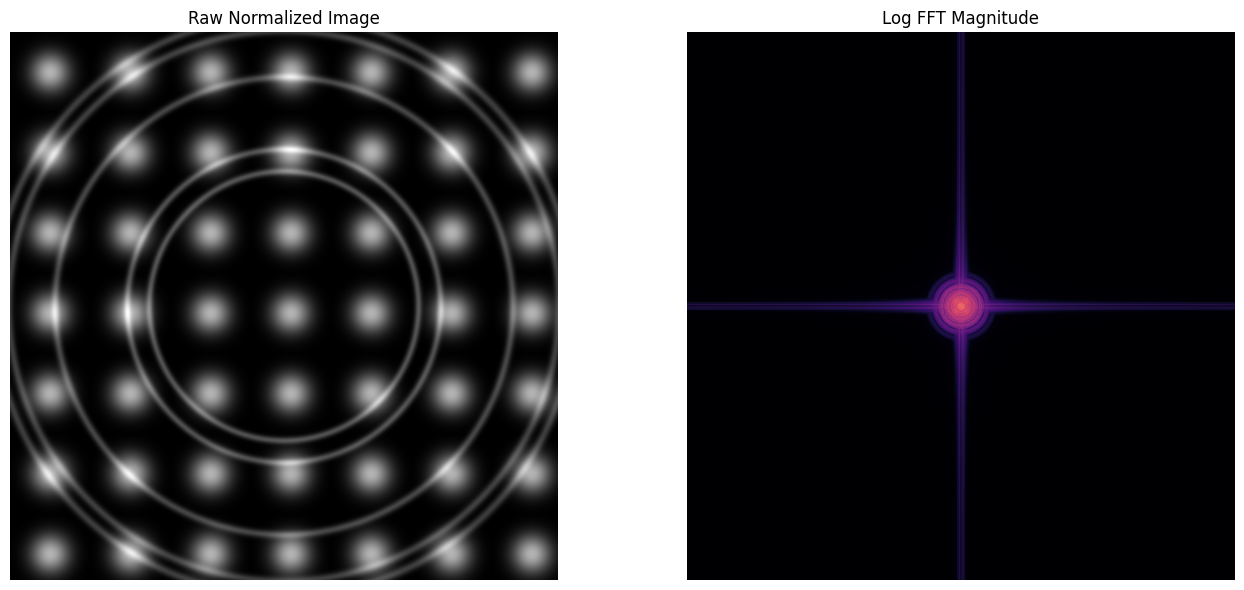

In [90]:
# Convert the dataframe to a NumPy array
image_data = image

# Normalize the image for display
image_norm = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

# Compute FFT and log-magnitude
fft_data = np.fft.fftshift(np.fft.fft2(image_norm))
log_fft_mag = np.log1p(np.abs(fft_data))

# Plot raw image and FFT magnitude
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].imshow(image_norm, cmap='gray')
axs[0].set_title("Raw Normalized Image")
axs[0].axis('off')

axs[1].imshow(log_fft_mag, cmap='magma')
axs[1].set_title("Log FFT Magnitude")
axs[1].axis('off')

plt.tight_layout()
plt.show()


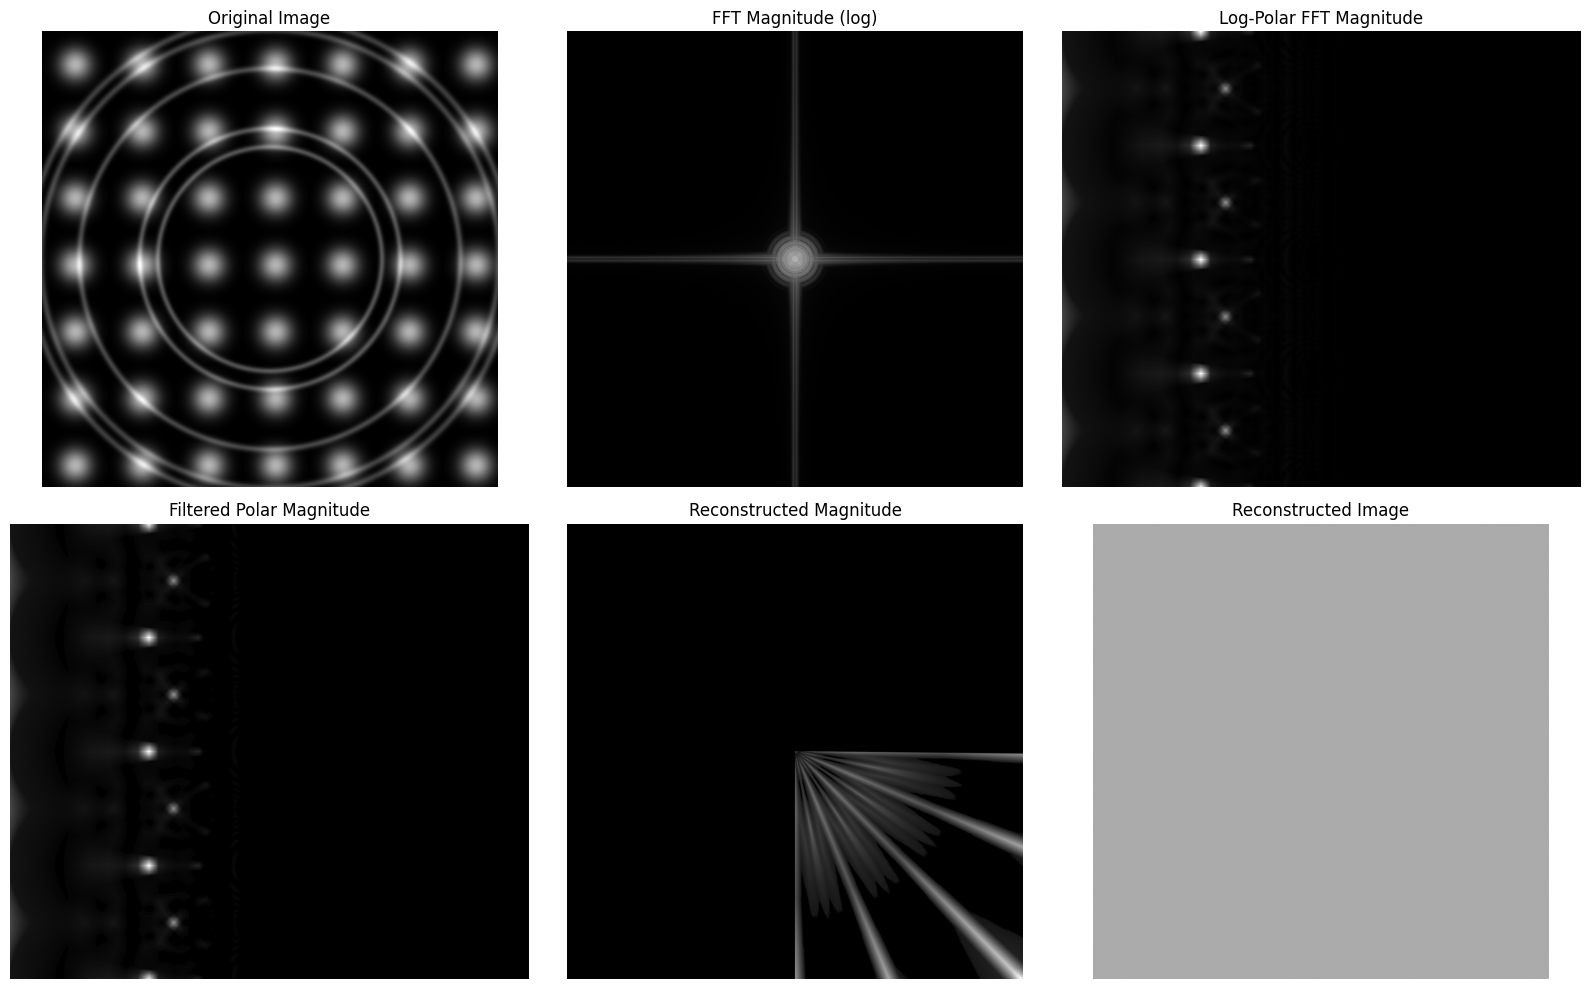

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp_polar, warp
from skimage.io import imread
from skimage.util import img_as_float

# Load image
image = np.genfromtxt('thinfilm-on-substrate.csv', delimiter=',')

# Ensure it's float
image = image.astype(np.float32)

# Step 1: FFT
F = np.fft.fftshift(np.fft.fft2(image))
mag = np.abs(F)
phase = np.angle(F)

# Step 2: Convert to log-polar
center = (image.shape[0] // 2, image.shape[1] // 2)
polar_mag = warp_polar(mag, center=center, scaling='log')

# Step 3: Filter in polar domain
threshold = np.mean(polar_mag)
filtered_polar_mag = np.where(polar_mag > threshold, polar_mag, 0)

# Step 4: Define inverse_map: Cartesian -> Polar coordinates
def cartesian_to_polar(coords):
    # coords: Nx2 array of (row, col) for each output pixel
    y, x = coords[:, 0] - center[0], coords[:, 1] - center[1]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Normalize r and theta to match polar_mag dimensions
    r_log = np.log1p(r)  # log-scale to match warp_polar(log)
    r_idx = r_log / np.log1p(np.hypot(*center)) * (polar_mag.shape[0] - 1)
    theta = (theta + 2 * np.pi) % (2 * np.pi)
    theta_idx = theta / (2 * np.pi) * (polar_mag.shape[1] - 1)

    return np.column_stack((r_idx, theta_idx))

# Step 5: Warp polar magnitude back to Cartesian coordinates
reconstructed_mag = warp(
    filtered_polar_mag,
    inverse_map=cartesian_to_polar,
    output_shape=image.shape,
    order=1,
    preserve_range=True
)

# Step 6: Reconstruct filtered FFT and inverse FFT
reconstructed_F = reconstructed_mag * np.exp(1j * phase)
reconstructed_image = np.fft.ifft2(np.fft.ifftshift(reconstructed_F)).real

# Normalize
reconstructed_image_norm = (reconstructed_image - np.min(reconstructed_image)) / (np.max(reconstructed_image) - np.min(reconstructed_image))

# --- Visualization ---
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(np.log1p(mag), cmap='gray')
axs[0, 1].set_title('FFT Magnitude (log)')

axs[0, 2].imshow(polar_mag, cmap='gray', aspect='auto')
axs[0, 2].set_title('Log-Polar FFT Magnitude')

axs[1, 0].imshow(filtered_polar_mag, cmap='gray', aspect='auto')
axs[1, 0].set_title('Filtered Polar Magnitude')

axs[1, 1].imshow(reconstructed_mag, cmap='gray')
axs[1, 1].set_title('Reconstructed Magnitude')

axs[1, 2].imshow(reconstructed_image_norm, cmap='gray')
axs[1, 2].set_title('Reconstructed Image')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


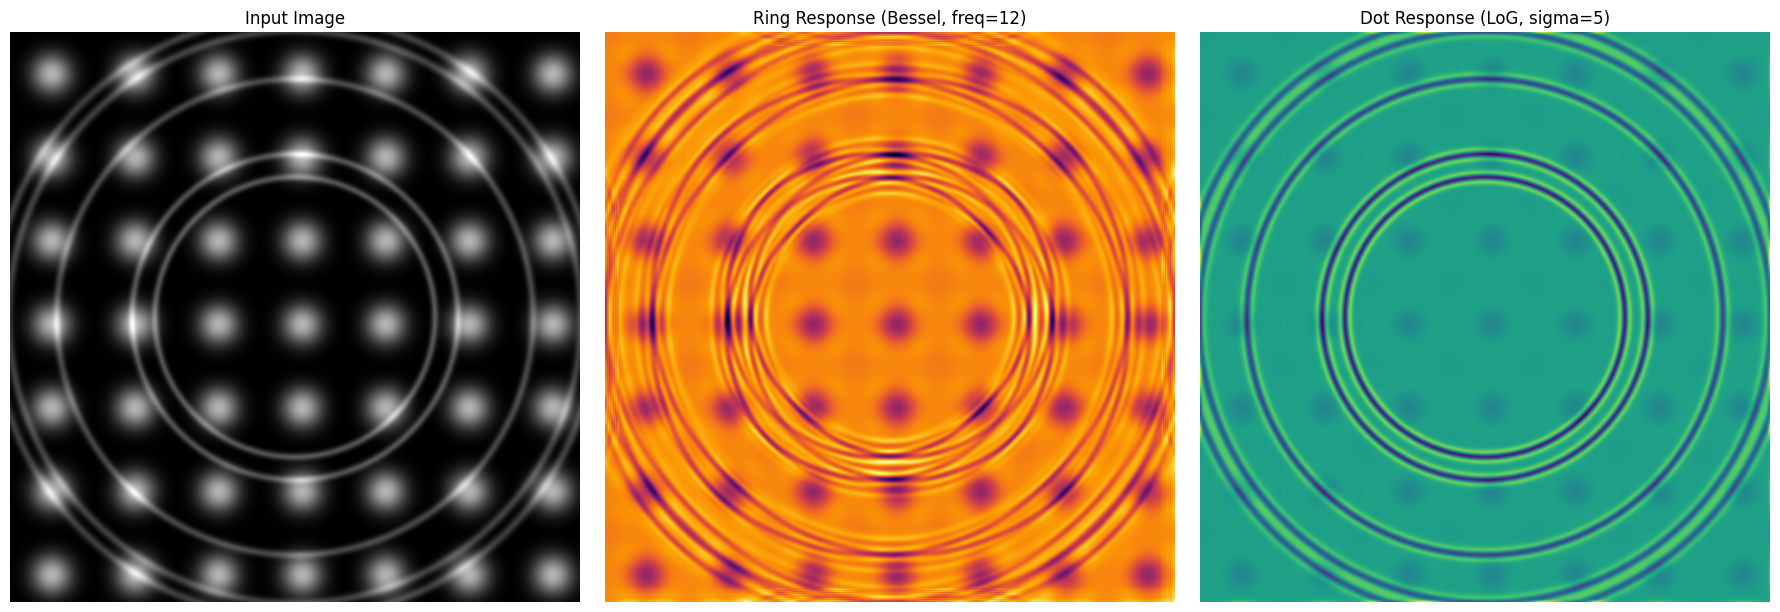

In [9]:
from scipy.special import j0
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_laplace

def bessel_ring_kernel(size=101, freq=12):
    """Generates a circular Bessel-based kernel."""
    y, x = np.indices((size, size)) - size // 2
    r = np.sqrt(x**2 + y**2)
    k = 2 * np.pi * freq / size
    kernel = j0(k * r)
    kernel -= np.mean(kernel)
    return kernel.astype(np.float32)

def laplacian_of_gaussian_kernel(size=101, sigma=5):
    """Generates a Laplacian of Gaussian (LoG) kernel."""
    y, x = np.indices((size, size)) - size // 2
    r2 = x**2 + y**2
    norm = r2 / (2 * sigma**2)
    log_kernel = (norm - 1) * np.exp(-norm)
    log_kernel -= np.mean(log_kernel)
    return log_kernel.astype(np.float32)

# Parameters (adjustable)
kernel_size = 101
bessel_freq = 12
log_sigma = 5

# Generate kernels
kernel_ring = bessel_ring_kernel(size=kernel_size, freq=bessel_freq)
kernel_dot = laplacian_of_gaussian_kernel(size=kernel_size, sigma=log_sigma)

# Convolve with the image
ring_response = convolve(image_small, kernel_ring, mode='reflect')
dot_response = convolve(image_small, kernel_dot, mode='reflect')

# Normalize for display
ring_response_norm = (ring_response - ring_response.min()) / (ring_response.max() - ring_response.min())
dot_response_norm = (dot_response - dot_response.min()) / (dot_response.max() - dot_response.min())

# Plot responses
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image_small, cmap='gray')
axs[0].set_title("Input Image")

axs[1].imshow(ring_response_norm, cmap='inferno')
axs[1].set_title(f"Ring Response (Bessel, freq={bessel_freq})")

axs[2].imshow(dot_response_norm, cmap='viridis')
axs[2].set_title(f"Dot Response (LoG, sigma={log_sigma})")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


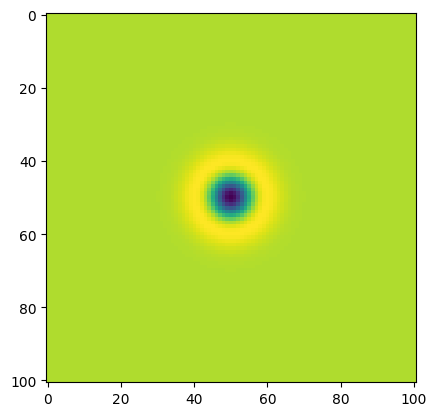

In [12]:
plt.imshow(kernel_ring)
plt.imshow(kernel_dot)

/home/jca92/anaconda3/envs/radial/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 511, 512])) that is different to the input size (torch.Size([1, 8, 511, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss = 0.06345
Epoch 20: Loss = 0.05756
Epoch 40: Loss = 0.05687
Epoch 60: Loss = 0.05662
Epoch 80: Loss = 0.05646
Epoch 100: Loss = 0.05634
Epoch 120: Loss = 0.05627
Epoch 140: Loss = 0.05621
Epoch 160: Loss = 0.05617
Epoch 180: Loss = 0.05614


TypeError: Invalid shape (8, 511, 512) for image data

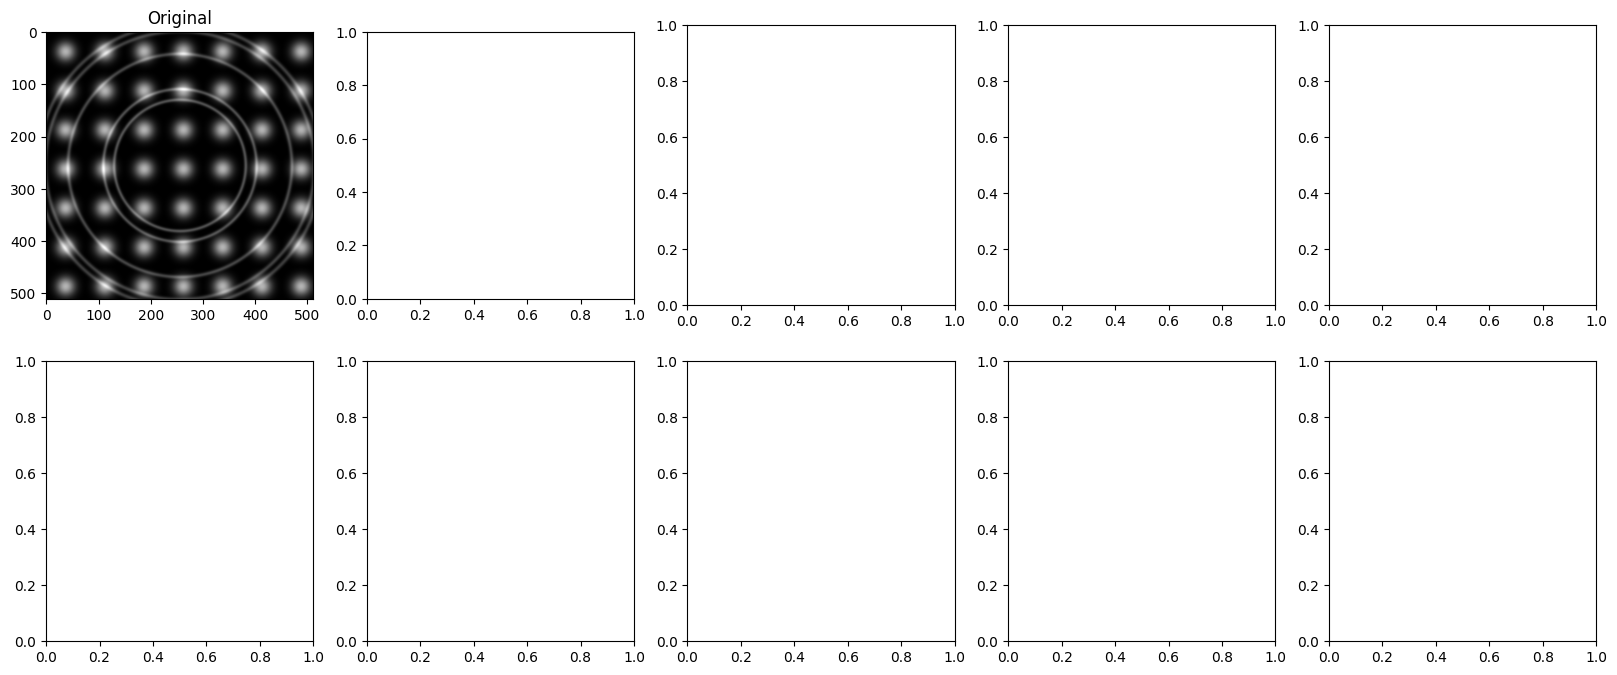

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.special import j0
import matplotlib.pyplot as plt
from skimage.transform import resize
import pandas as pd

# ---- Load and prepare image ----
df = pd.read_csv("thinfilm-on-substrate.csv")
image = df.to_numpy()
image = (image - image.min()) / (image.max() - image.min())
image_small = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)
img_tensor = torch.from_numpy(image_small).float().unsqueeze(0).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)

# ---- Radial Kernel Generator ----
def bessel_kernel(size=51, freq=12):
    y, x = np.indices((size, size)) - size // 2
    r = np.sqrt(x**2 + y**2)
    k = 2 * np.pi * freq / size
    kernel = j0(k * r)
    kernel -= kernel.mean()
    return kernel.astype(np.float32)

# ---- Learnable Model ----
class RadialDecomposer(nn.Module):
    def __init__(self, n_kernels=8, kernel_size=51, init_freqs=None):
        super().__init__()
        self.n_kernels = n_kernels
        self.kernel_size = kernel_size

        if init_freqs is None:
            init_freqs = np.linspace(4, 30, n_kernels)

        # Build radial basis as fixed filters
        kernels = [bessel_kernel(kernel_size, f) for f in init_freqs]
        kernel_bank = np.stack(kernels)  # shape (n_kernels, H, W)
        self.register_buffer('kernel_bank', torch.from_numpy(kernel_bank[:, None, :, :]))  # (n,1,k,k)

        # Learnable non-negative activations
        self.activation = nn.Conv2d(1, n_kernels, kernel_size=1, bias=False)
        nn.init.uniform_(self.activation.weight, a=0.01, b=0.1)

    def forward(self, x):
        A = F.relu(self.activation(x))  # non-negative activations: (B, n, H, W)
        K = self.kernel_bank  # (n, 1, k, k)
        I_hat = F.conv2d(A, K, padding=self.kernel_size // 2, groups=self.n_kernels)
        return I_hat, A

# ---- Train Loop ----
model = RadialDecomposer(n_kernels=8, kernel_size=51).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

for epoch in range(200):
    optimizer.zero_grad()
    I_hat, A = model(img_tensor)
    loss = loss_fn(I_hat, img_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5f}")

# ---- Visualize Activations ----
with torch.no_grad():
    I_hat, A = model(img_tensor)

A_np = A.squeeze().cpu().numpy()  # shape (n_kernels, H, W)
I_np = img_tensor.squeeze().cpu().numpy()
I_hat_np = I_hat.squeeze().cpu().numpy()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs[0, 0].imshow(I_np, cmap='gray'); axs[0, 0].set_title("Original")
axs[0, 1].imshow(I_hat_np, cmap='gray'); axs[0, 1].set_title("Reconstructed")

for i in range(8):
    axs[1 if i < 5 else 0, i % 5].imshow(A_np[i], cmap='inferno')
    axs[1 if i < 5 else 0, i % 5].set_title(f"Activation {i}")

for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()


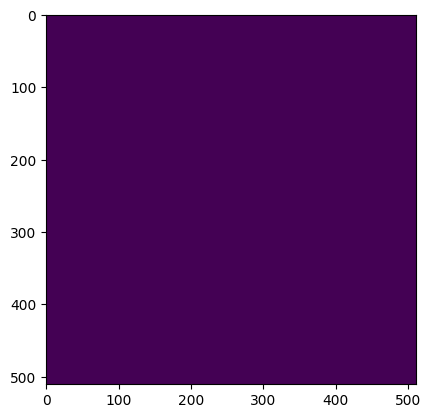

In [25]:
plt.imshow(I_hat_np[6])

In [46]:
# Re-run the full implementation after kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load and normalize image
# --------------------------
image = np.genfromtxt('thinfilm-on-substrate.csv', delimiter=',').astype(np.float32)
max_dim = max(image.shape)
padded_image = np.pad(image, ((0, max_dim - image.shape[0]), (0, max_dim - image.shape[1])), mode='constant')
image = padded_image / np.max(padded_image)

# --------------------------
# Differentiable Tiling Model
# --------------------------
class SoftTiledKernelNet(nn.Module):
    def __init__(self, kernel_size, init_stride, width, img_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size

        # Learnable stride (float)
        self.offset_fp = nn.Parameter(torch.tensor(init_stride, dtype=torch.float32))

        # Learnable kernel template
        grid = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size), indexing='ij')
        dx = grid[0] - kernel_size / 2
        dy = grid[1] - kernel_size / 2
        kernel = np.exp(-(dx**2 + dy**2) / (2 * width**2)).astype(np.float32)
        self.template = nn.Parameter(torch.tensor(kernel).unsqueeze(0).unsqueeze(0))  # (1,1,H,W)

    def forward(self):
        stride = self.offset_fp.clamp(min=4.0)  # Ensure positive stride
        n_x = int(self.img_size / stride.item()) + 1
        n_y = int(self.img_size / stride.item()) + 1

        device = self.template.device
        coords = []
        for i in range(n_x):
            for j in range(n_y):
                x = (i * stride.item()) / (self.img_size / 2) - 1  # Normalize to [-1, 1]
                y = (j * stride.item()) / (self.img_size / 2) - 1
                coords.append([y, x])  # Note: grid_sample uses (y, x) format

        grid = torch.tensor(coords, device=device).view(1, n_x * n_y, 1, 2)
        grid = grid.expand(-1, -1, self.kernel_size * self.kernel_size, -1)
        base_grid = F.affine_grid(torch.eye(2, 3).unsqueeze(0).repeat(n_x * n_y, 1, 1).to(device),
                                  [n_x * n_y, 1, self.kernel_size, self.kernel_size], align_corners=True)
        grid = base_grid + grid.view(n_x * n_y, self.kernel_size, self.kernel_size, 2)

        # Sample the template and place it at all positions
        template = F.relu(self.template)  # Ensure non-negative kernel
        tiled = F.grid_sample(template.expand(n_x * n_y, -1, -1, -1), grid, align_corners=True)

        # Combine all tiles into full image
        output = torch.zeros((1, 1, self.img_size, self.img_size), device=device)
        for idx, (i, j) in enumerate([(i, j) for i in range(n_x) for j in range(n_y)]):
            x = int(i * stride.item())
            y = int(j * stride.item())
            if x + self.kernel_size <= self.img_size and y + self.kernel_size <= self.img_size:
                output[:, :, x:x+self.kernel_size, y:y+self.kernel_size] += tiled[idx]

        return output

# --------------------------
# Setup and Training
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params = dict(kernel_size=300, init_stride=32.0, width=5.0, img_size=2048)

target = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
model = SoftTiledKernelNet(**params).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

# --------------------------
# Training Loop
# --------------------------
for epoch in range(30):
    optimizer.zero_grad()
    output = model()
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f} | Stride: {model.offset_fp.item():.2f}")

# --------------------------
# Visualization
# --------------------------
output_np = output.detach().cpu().squeeze().numpy()
template_np = model.template.detach().cpu().squeeze().numpy()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Target Pattern")

axs[1].imshow(output_np, cmap='gray')
axs[1].set_title("Model Output")

axs[2].imshow(template_np, cmap='inferno')
axs[2].set_title("Learned Template")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


Epoch 0 | Loss: 0.082545 | Stride: 32.00
Epoch 5 | Loss: 0.065518 | Stride: 32.00
Epoch 10 | Loss: 0.058191 | Stride: 32.00


KeyboardInterrupt: 

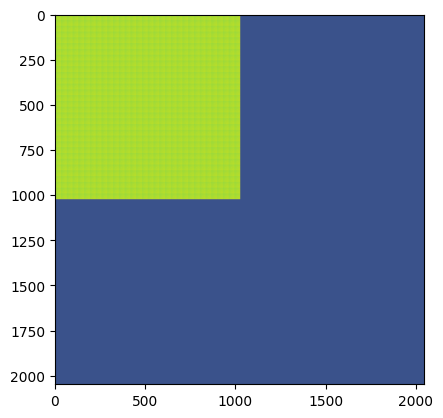

In [41]:
plt.imshow(output_np)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load and normalize image
# --------------------------
image = np.genfromtxt('thinfilm-on-substrate.csv', delimiter=',').astype(np.float32)
max_dim = max(image.shape)
padded_image = np.pad(image, ((0, max_dim - image.shape[0]), (0, max_dim - image.shape[1])), mode='constant')
image = padded_image / np.max(padded_image)

# --------------------------
# Efficient Tiled Reconstruction via Upsampled Grid
# --------------------------
class StrideApproxTiler(nn.Module):
    def __init__(self, kernel_size, init_stride, width, img_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size

        # Learnable template
        grid = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size), indexing='ij')
        dx = grid[0] - kernel_size / 2
        dy = grid[1] - kernel_size / 2
        kernel = np.exp(-(dx**2 + dy**2) / (2 * width**2)).astype(np.float32)
        self.kernel = nn.Parameter(torch.tensor(kernel).unsqueeze(0).unsqueeze(0))  # (1,1,H,W)

        # Learnable stride approximation
        self.log_stride = nn.Parameter(torch.tensor(np.log(init_stride), dtype=torch.float32))

    def forward(self):
        stride = torch.exp(self.log_stride)
        tile_spacing = stride / self.img_size  # normalize to (0, 1)

        # Determine approximate number of tiles
        num_tiles_x = int(self.img_size / stride.item()) + 1
        num_tiles_y = int(self.img_size / stride.item()) + 1

        # Generate sparse activation map
        grid_sparse = torch.zeros((1, 1, num_tiles_x, num_tiles_y), device=self.kernel.device)
        grid_sparse[0, 0, :, :] = 1.0  # All 1's for tiling

        # Upsample to full image size
        upsampled = F.interpolate(grid_sparse, size=(self.img_size, self.img_size), mode='bilinear', align_corners=True)

        # Convolve upsampled activation map with large template kernel
        output = F.conv2d(upsampled, F.relu(self.kernel), padding=self.kernel_size // 2)
        return output[:, :, :self.img_size, :self.img_size]


# --------------------------
# Setup and Training
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params = dict(kernel_size=300, init_stride=64.0, width=8.0, img_size=2048)

target = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
model = StrideApproxTiler(**params).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# --------------------------
# Training Loop
# --------------------------
for epoch in range(30):
    optimizer.zero_grad()
    output = model()
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f} | Stride: {torch.exp(model.log_stride).item():.2f}")

# --------------------------
# Visualization
# --------------------------
output_np = output.detach().cpu().squeeze().numpy()
template_np = model.kernel.detach().cpu().squeeze().numpy()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Target Pattern")

axs[1].imshow(output_np, cmap='gray')
axs[1].set_title("Model Output")

axs[2].imshow(template_np, cmap='inferno')
axs[2].set_title("Learned Template")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Load and normalize image
# --------------------------
image = np.genfromtxt('thinfilm-on-substrate.csv', delimiter=',').astype(np.float32)
max_dim = max(image.shape)
padded_image = np.pad(image, ((0, max_dim - image.shape[0]), (0, max_dim - image.shape[1])), mode='constant')
image = padded_image / np.max(padded_image)

# --------------------------
# Generate 2D Gaussian Kernel
# --------------------------
def make_gaussian_kernel(size, width, device):
    ax = torch.linspace(-1, 1, size, device=device)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * width**2))
    return kernel / kernel.sum()

# --------------------------
# Differentiable Tiler with Continuous Affine Grid
# --------------------------
class AffineTiler(nn.Module):
    def __init__(self, img_size, kernel_size, init_stride, init_width):
        super().__init__()
        self.img_size = img_size
        self.kernel_size = kernel_size

        self.log_width = nn.Parameter(torch.tensor(np.log(init_width), dtype=torch.float32))
        self.stride_fp = nn.Parameter(torch.tensor(init_stride, dtype=torch.float32))

        self.register_buffer('ref_image', torch.zeros(1, 1, img_size, img_size))

    def forward(self):
        stride = self.stride_fp.clamp(min=4.0, max=self.img_size / 2)
        width = torch.exp(self.log_width)

        kernel = make_gaussian_kernel(self.kernel_size, width, self.ref_image.device)
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

        # Number of tiles in each direction
        n_tiles = int((self.img_size - self.kernel_size) // stride.item()) + 1

        # Generate affine matrices for each tile
        affine_matrices = []
        for i in range(n_tiles):
            for j in range(n_tiles):
                # Translation in normalized coordinates [-1, 1]
                tx = (i * stride) / (self.img_size / 2) - 1
                ty = (j * stride) / (self.img_size / 2) - 1
                scale = self.kernel_size / self.img_size

                theta = torch.tensor([
                    [scale, 0.0, tx],
                    [0.0, scale, ty]
                ], dtype=torch.float32, device=self.ref_image.device)
                affine_matrices.append(theta)

        theta = torch.stack(affine_matrices)  # (N, 2, 3)

        # Generate sampling grid
        grid = F.affine_grid(theta, size=(theta.shape[0], 1, self.img_size, self.img_size), align_corners=False)

        # Apply Gaussian to each affine-transformed location
        warped = F.grid_sample(kernel.expand(theta.shape[0], -1, -1, -1), grid, align_corners=False)

        # Sum all contributions to canvas
        canvas = warped.sum(dim=0, keepdim=True)  # shape (1, 1, H, W)
        return canvas

# --------------------------
# Setup
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params = dict(kernel_size=64, init_stride=128.0, init_width=10.0, img_size=2048)

target = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
model = AffineTiler(**params).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

# --------------------------
# Train
# --------------------------
stride_trace = []
width_trace = []

for epoch in range(50):
    optimizer.zero_grad()
    output = model()
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    stride_val = model.stride_fp.item()
    width_val = torch.exp(model.log_width).item()
    stride_trace.append(stride_val)
    width_trace.append(width_val)

    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | Loss: {loss.item():.6f} | Stride: {stride_val:.2f} | Width: {width_val:.2f}")

# --------------------------
# Visualize
# --------------------------
output_np = output.detach().cpu().squeeze().numpy()
template_np = make_gaussian_kernel(params['kernel_size'], torch.exp(model.log_width), device='cpu').numpy()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Target Pattern")

axs[1].imshow(output_np, cmap='gray')
axs[1].set_title("Model Output")

axs[2].imshow(template_np, cmap='inferno')
axs[2].set_title("Learned Template (Gaussian)")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


Epoch 00 | Loss: 0.045537 | Stride: 128.00 | Width: 9.51
Epoch 05 | Loss: 0.045535 | Stride: 128.00 | Width: 7.40
Epoch 10 | Loss: 0.045533 | Stride: 128.00 | Width: 5.71
Epoch 15 | Loss: 0.045528 | Stride: 128.00 | Width: 4.36
Epoch 20 | Loss: 0.045519 | Stride: 128.00 | Width: 3.28
Epoch 25 | Loss: 0.045503 | Stride: 128.00 | Width: 2.42
Epoch 30 | Loss: 0.045472 | Stride: 128.00 | Width: 1.75
Epoch 35 | Loss: 0.045411 | Stride: 128.00 | Width: 1.25
Epoch 40 | Loss: 0.045296 | Stride: 128.00 | Width: 0.87
Epoch 45 | Loss: 0.045101 | Stride: 128.00 | Width: 0.59


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TilerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=2),  # H/2
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2, padding=2),  # H/4
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.head = nn.Linear(32, 2)  # Outputs: log_stride, log_width

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        log_stride, log_width = self.head(x).split(1, dim=1)
        return torch.exp(log_stride), torch.exp(log_width)

class TilerDecoder(nn.Module):
    def __init__(self, img_size, kernel_size):
        super().__init__()
        self.img_size = img_size
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

    def forward(self, stride, width):
        stride = stride.clamp(min=4.0, max=self.img_size / 2)
        width = width.clamp(min=1.0, max=self.kernel_size / 2)

        kernel = make_gaussian_kernel(self.kernel_size, width, device=device)
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # shape (1, 1, k, k)

        canvas = torch.zeros(1, 1, self.img_size, self.img_size, device=device)

        n_tiles = int((self.img_size - self.kernel_size) // stride.item()) + 1

        for i in range(n_tiles):
            for j in range(n_tiles):
                x = int(i * stride.item())
                y = int(j * stride.item())

                i0 = max(0, x)
                i1 = min(self.img_size, x + self.kernel_size)
                j0 = max(0, y)
                j1 = min(self.img_size, y + self.kernel_size)

                ki0 = 0
                kj0 = 0
                if i1 - i0 < self.kernel_size:
                    ki0 = self.kernel_size - (i1 - i0)
                if j1 - j0 < self.kernel_size:
                    kj0 = self.kernel_size - (j1 - j0)

                canvas[:, :, i0:i1, j0:j1] += kernel[:, :, ki0:, kj0:]

        return canvas


class TilingAutoEncoder(nn.Module):
    def __init__(self, img_size, kernel_size):
        super().__init__()
        self.encoder = TilerEncoder()
        self.decoder = TilerDecoder(img_size, kernel_size)

    def forward(self, x):
        stride, width = self.encoder(x)
        reconstruction = self.decoder(stride.squeeze(1), width.squeeze(1))
        return reconstruction, stride, width


In [ ]:
model = TilingAutoEncoder(img_size=2048, kernel_size=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
# --------------------------
# Load and normalize image
# --------------------------
image = np.genfromtxt('thinfilm-on-substrate.csv', delimiter=',').astype(np.float32)
max_dim = max(image.shape)
padded_image = np.pad(image, ((0, max_dim - image.shape[0]), (0, max_dim - image.shape[1])), mode='constant')
image = padded_image / np.max(padded_image)

# --------------------------
# Generate 2D Gaussian Kernel
# --------------------------
def make_gaussian_kernel(size, width, device):
    ax = torch.linspace(-1, 1, size, device=device)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * width**2))
    return kernel / kernel.sum()

target = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

for epoch in range(100):
    optimizer.zero_grad()
    output, stride, width = model(target)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f} | Stride: {stride.item():.2f} | Width: {width.item():.2f}")


Epoch 0 | Loss: 0.045235 | Stride: 1.05 | Width: 0.93
